# Instead visit original documentation you will grasp every concept of streaming clearly
https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html

### Evolution of the Apache Spark Stream Processing Engine
Stream processing is defined as the continuous processing of endless streams of data.
With the advent of big data, stream processing systems transitioned from single-node
processing engines to multiple-node, distributed processing engines. Traditionally,
distributed stream processing has been implemented with a record-at-a-time process‐
ing model,<br>

This traditional approach was challenged by Apache Spark when it introduced Spark
Streaming (also called DStreams). It introduced the idea of micro-batch stream pro‐
cessing, where the streaming computation is modeled as a continuous series of small,
map/reduce-style batch processing jobs (hence, “micro-batches”) on small chunks of
the stream data.

## The Programming Model of Structured Streaming
“Table” is a well-known concept that developers are familiar with when building
batch applications. Structured Streaming extends this concept to streaming applica‐
tions by treating a stream as an unbounded, continuously appended table, as illustra‐
ted in
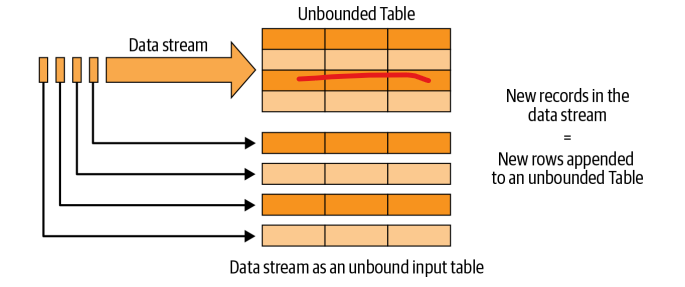
Every new record received in the data stream is like a new row being appended to the
unbounded input table

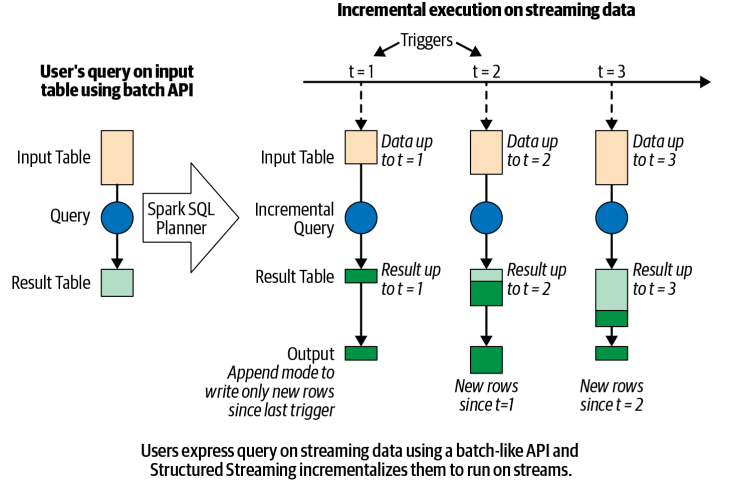

The last part of the model is the output mode. Each time the result table is updated,
the developer will want to write the updates to an external system, such as a filesys‐
tem (e.g., HDFS, Amazon S3) or a database (e.g., MySQL, Cassandra). We usually
want to write output incrementally.

# Five Steps to Define a Streaming Query

In [ ]:
#Step 1: Define input sources
spark = SparkSession...
lines = (spark
 .readStream.format("socket")
 .option("host", "localhost")
 .option("port", 9999)
 .load())#code generates the lines DataFrame as an unbounded table of newlineseparated text data read from localhost:9999
#Apache Spark natively supports reading data streams from Apache
#Kafka and all the various file-based formats that DataFrameReader supports (Parquet,
#ORC, JSON, etc.)

In [ ]:
#Step 2: Transform data
from pyspark.sql.functions import *
words = lines.select(split(col("value"), "\\s").alias("word"))
counts = words.groupBy("word").count()

In [ ]:
#Step 3: Define output sink and output mode
writer = counts.writeStream.format("console").outputMode("complete")
#"console" as the output streaming sink and "complete" as
#the output mode(IMP:== Learn about output modes from web ex:- Append,Update,complete mode)

In [ ]:
#Step 4: Specify processing details
checkpointDir = "C\.."
writer2 = (writer
 .trigger(processingTime="1 second")
 .option("checkpointLocation", checkpointDir))

In [ ]:
#Step 5: Start the query
streamingQuery = writer2.start()

In [ ]:
from pyspark.sql.functions import *
spark = SparkSession...
lines = (spark
 .readStream.format("socket")
 .option("host", "localhost")
 .option("port", 9999)
 .load())
words = lines.select(split(col("value"), "\\s").alias("word"))
counts = words.groupBy("word").count()
checkpointDir = "..."
streamingQuery = (counts
 .writeStream
 .format("console").outputMode("complete")
 .trigger(processingTime="1 second")
 .option("checkpointLocation", checkpointDir)
 .start())
streamingQuery.awaitTermination()
# start() is a nonblocking method, so it will return as soon as the query has
# started in the background. If you want the main thread to block until the streaming
# query has terminated, you can use streamingQuery.awaitTermination(). If the
# query fails in the background with an error, awaitTermination() will also fail with
# that same exception.

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my_app").getOrCreate()

In [10]:
#lines = [['foo'],['foo'],['pow'],['pow'],['bam']]
lines = [['foo foo pow pow bam']]
columns = ["Subject"]
words = spark.createDataFrame(lines, columns)
words.show()

+-------------------+
|            Subject|
+-------------------+
|foo foo pow pow bam|
+-------------------+



In [12]:
#explode flattens the columns array value in row
from pyspark.sql.functions import *
lines = words.select(
   explode(
       split(words['Subject'], " ")
   ).alias("word")
)

In [14]:
lines.show()

+----+
|word|
+----+
| foo|
| foo|
| pow|
| pow|
| bam|
+----+



In [16]:
wordscount = lines.groupBy('word').count()

In [17]:
wordscount.show()

+----+-----+
|word|count|
+----+-----+
| foo|    2|
| bam|    1|
| pow|    2|
+----+-----+



# Window Operations on Event Time

Aggregations over a sliding event-time window are straightforward with Structured Streaming and are very similar to grouped aggregations. In a grouped aggregation, aggregate values (e.g. counts) are maintained for each unique value in the user-specified grouping column. In case of window-based aggregations, aggregate values are maintained for each window the event-time of a row falls into. Let’s understand this with an illustration.

Imagine our quick example is modified and the stream now contains lines along with the time when the line was generated. Instead of running word counts, we want to count words within 10 minute windows, updating every 5 minutes. That is, word counts in words received between 10 minute windows 12:00 - 12:10, 12:05 - 12:15, 12:10 - 12:20, etc. Note that 12:00 - 12:10 means data that arrived after 12:00 but before 12:10. Now, consider a word that was received at 12:07. This word should increment the counts corresponding to two windows 12:00 - 12:10 and 12:05 - 12:15. So the counts will be indexed by both, the grouping key (i.e. the word) and the window (can be calculated from the event-time). 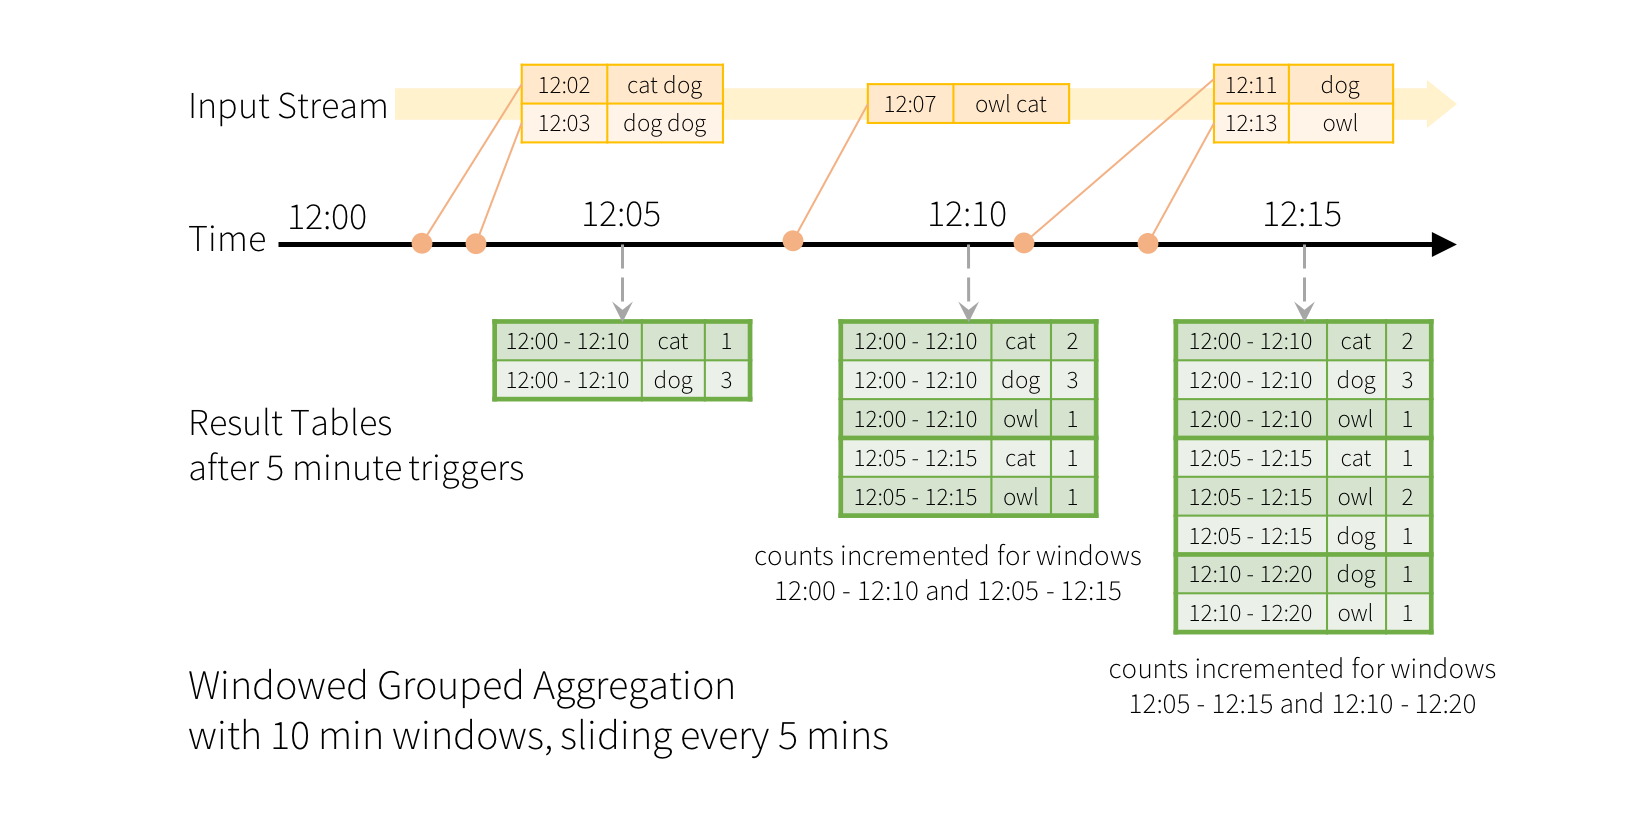

In [ ]:
words = ...  # streaming DataFrame of schema { timestamp: Timestamp, word: String }

# Group the data by window and word and compute the count of each group
windowedCounts = words.groupBy(
    window(words.timestamp, "10 minutes", "5 minutes"),
    words.word
).count()

# Handling late data using watermarking
Now consider what happens if one of the events arrives late to the application. For example, say, a word generated at 12:04 (i.e. event time) could be received by the application at 12:11. The application should use the time 12:04 instead of 12:11 to update the older counts for the window 12:00 - 12:10. This occurs naturally in our window-based grouping – Structured Streaming can maintain the intermediate state for partial aggregates for a long period of time such that late data can update aggregates of old windows correctly, as illustrated below.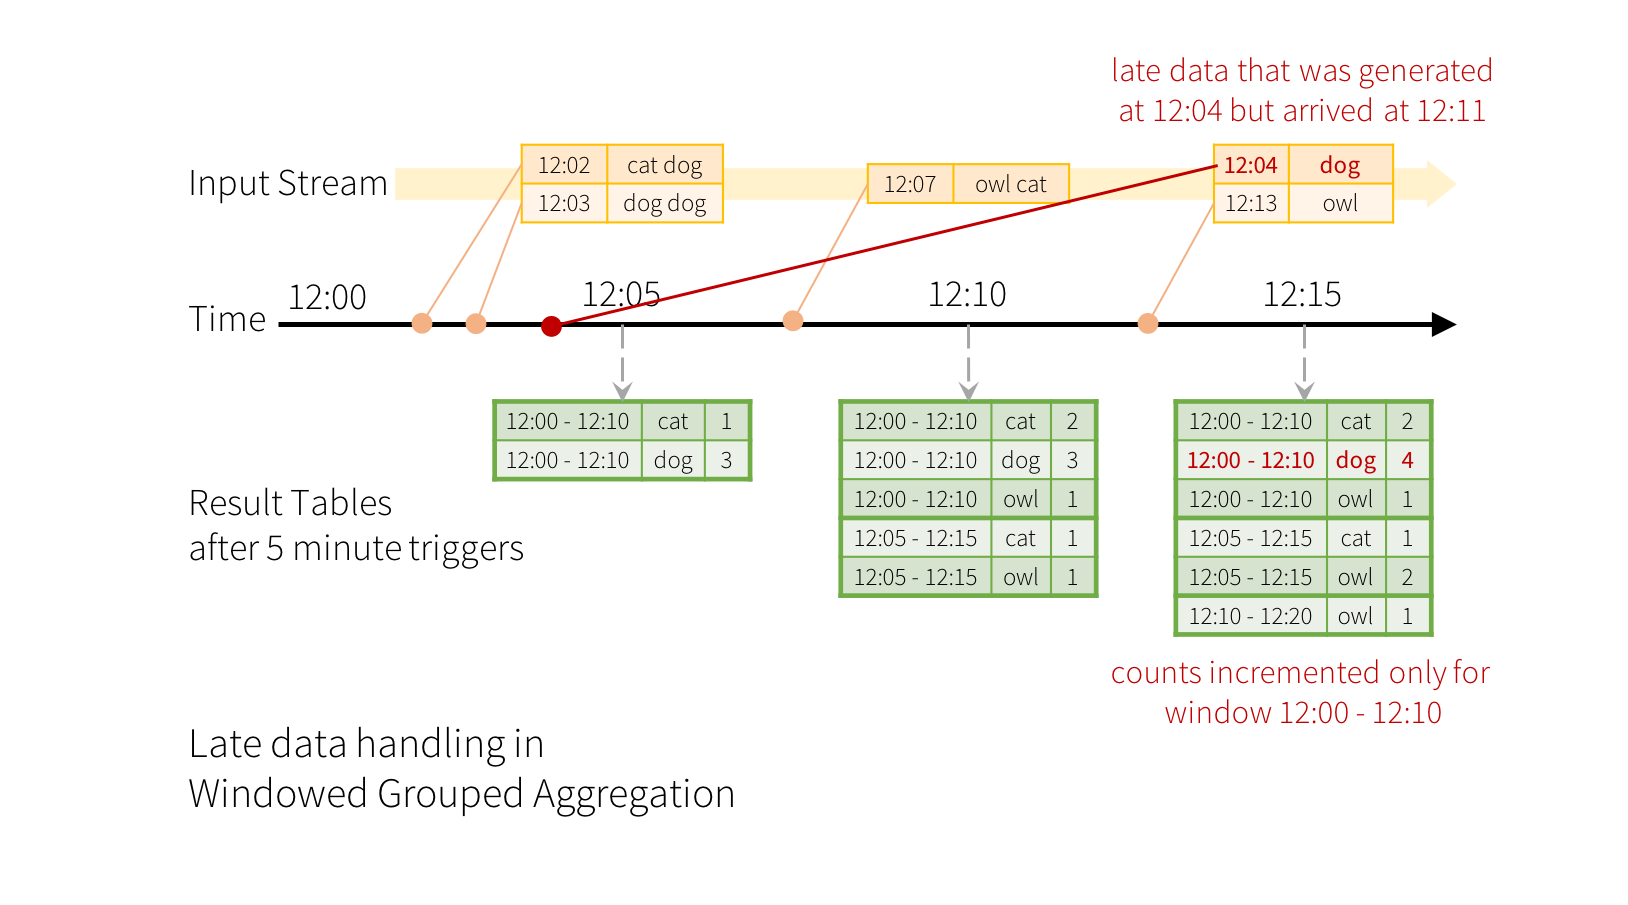

In [ ]:
words = ...  # streaming DataFrame of schema { timestamp: Timestamp, word: String }

# Group the data by window and word and compute the count of each group
windowedCounts = words \
    .withWatermark("timestamp", "10 minutes") \
    .groupBy(
        window(words.timestamp, "10 minutes", "5 minutes"),
        words.word) \
    .count()

FOR FURTHER documentation visit https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#handling-late-data-and-watermarking

## Output Sinks 

In [ ]:
# File sink - Stores the output to a directory.
writeStream
    .format("parquet")        // can be "orc", "json", "csv", etc.
    .option("path", "path/to/destination/dir")
    .start()

#Kafka sink - Stores the output to one or more topics in Kafka.
writeStream
    .format("kafka")
    .option("kafka.bootstrap.servers", "host1:port1,host2:port2")
    .option("topic", "updates")
    .start()
    
#CONSOLE sink print the ouput to console 
writeStream
    .format("console")
    .start()


In [ ]:
#call start() to start the execution of the query.
# ========== DF with no aggregations ==========
noAggDF = deviceDataDf.select("device").where("signal > 10")   

# Print new data to console
noAggDF \
    .writeStream \
    .format("console") \
    .start()

# Write new data to Parquet files
noAggDF \
    .writeStream \
    .format("parquet") \
    .option("checkpointLocation", "path/to/checkpoint/dir") \
    .option("path", "path/to/destination/dir") \
    .start()

# ========== DF with aggregation ==========
aggDF = df.groupBy("device").count()

# Print updated aggregations to console
aggDF \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

# Have all the aggregates in an in-memory table. The query name will be the table name
aggDF \
    .writeStream \
    .queryName("aggregates") \
    .outputMode("complete") \
    .format("memory") \
    .start()

spark.sql("select * from aggregates").show()   # interactively query in-memory table

# Foreach and ForeachBatch
Foreachbatch:- it enables arbitrary operations on the output of streaming query 

foreach:- foreach runs for every element in that batch, loop over each element in the dataset

## Triggers
It define the timing of streaming data processing, whether the query is going to be executed as micro-batch query with a fixed batch interval or as a continuous processing query

In [ ]:
# Default trigger (runs micro-batch as soon as it can)
df.writeStream \
  .format("console") \
  .start()

# ProcessingTime trigger with two-seconds micro-batch interval
df.writeStream \
  .format("console") \
  .trigger(processingTime='2 seconds') \
  .start()

# One-time trigger
df.writeStream \
  .format("console") \
  .trigger(once=True) \
  .start()

# Continuous trigger with one-second checkpointing interval
df.writeStream
  .format("console")
  .trigger(continuous='1 second')
  .start()

## Managing Streaming Queries
The StreamingQuery object created when a query is started can be used to monitor and manage the query.

In [ ]:
query = df.writeStream.format("console").start()   # get the query object

query.id()          # get the unique identifier of the running query that persists across restarts from checkpoint data

query.runId()       # get the unique id of this run of the query, which will be generated at every start/restart

query.name()        # get the name of the auto-generated or user-specified name

query.explain()   # print detailed explanations of the query

query.stop()      # stop the query

query.awaitTermination()   # block until query is terminated, with stop() or with error

query.exception()       # the exception if the query has been terminated with error

query.recentProgress  # a list of the most recent progress updates for this query

query.lastProgress    # the most recent progress update of this streaming query

## Continuous Processing
Continuous Processing can achieve end-to-end latencies as low as 1 millisecond with at-least-once guarantees fault-tolerance

In [ ]:
spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2") \
  .option("subscribe", "topic1") \
  .load() \
  .selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)") \
  .writeStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2") \
  .option("topic", "topic1") \
  .trigger(continuous="1 second") \     # only change in query
  .start()